In [1]:
import sys
import os
work_dir="/kaggle/working/"
def init_project(source_code, source_code_url):
    if not os.path.exists(source_code):
        os.system(f'git clone {source_code_url}')
    os.system(f"cd {source_code} && git pull")
    sys.path.append(source_code)
    os.system(f"pip install -U -r {source_code}/requirements.txt")

source_code="/kaggle/working/co2-images-inv-dl"
source_code_url="https://github.com/xiaoxubeii/co2-images-inv-dl"
init_project(source_code, source_code_url)

import uuid
import tools.matplotlib_functions as mympf
import sys
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from cmcrameri import cm
from hydra import compose, initialize
from omegaconf import OmegaConf, DictConfig
from scipy.optimize import differential_evolution
from sklearn import preprocessing
from datetime import datetime
import kagglehub
import wandb
import random
import string
import shutil
import subprocess
from importlib import reload
from omegaconf import OmegaConf
from datetime import datetime
import yaml
import collections.abc
import copy
import re
%matplotlib inline
mympf.setMatplotlibParam()
plt.viridis()

def default():
    return default_config.copy()

def update(cfg, u):
    for k,v in u.items():
        OmegaConf.update(cfg, k, v, merge=True)

def get_config(cfg):
    d=OmegaConf.to_container(cfg, resolve=True)
    def _dotter(d, key, dots):
        if isinstance(d, dict):
            for k in d:
                _dotter(d[k], key + '.' + k if key else k, dots)
        else:
            dots.append(key)
        return dots
    return {k:OmegaConf.select(cfg, k) for k in _dotter(d, '', [])}


def init_cfg(config):
    cfg=OmegaConf.create()
    update(cfg, default_config)
    update(cfg, config)
    return cfg

def run_exp(py_file="main.py", cfg=None):
    config={}
    if cfg:
        config=get_config(cfg)
    return execute(source_code, py_file, **config)

def test_exp(py_file="test.py", cfg=None):
    config={}
    if cfg:
        config=get_config(cfg)
    return execute(source_code, py_file, t="test", **config)
    
def execute(base_path, file, t="experiment", **kwargs):
    os.system(f"cd {base_path} && git pull")
    run_cmd=[f'HYDRA_FULL_ERROR=1 python {base_path}/{file} +{t}={kwargs[t]}']
    git_id=subprocess.check_output(f"cd {base_path} && git rev-parse HEAD", shell=True).decode(sys.stdout.encoding)
    config=kwargs.copy()
    config["git_id"]=git_id.strip()
    config.pop(t)
    for k,v in config.items():
        v=re.sub(r"\'|\"", "", str(v))
        run_cmd.append(f"++{k}='{v}'")
    run_cmd=" ".join(run_cmd)
    print(run_cmd)
    os.system(run_cmd)
    
def execute_with_output(base_path, file, **kwargs):
    os.system(f"cd {base_path} && git pull")
    run_cmd=[f'python {base_path}/{file} +experiment={kwargs["experiment"]}']
    config=kwargs.copy()
    config.pop("experiment")
    for k,v in config.items():
        run_cmd.append(f"++{k}='{v}'")
    run_cmd=" ".join(run_cmd)
    print(run_cmd)
    return subprocess.check_output(run_cmd, shell=True).decode(sys.stdout.encoding)
    
def cutoff_ds(ds_path, num):
    ds=xr.open_dataset(ds_path)
    data={}
    for k in ds.variables:
        data[k]=ds.variables[k][:num]
    return xr.Dataset(data)

def sample_ds(ds_path, dest_path, num):
    dest_dir= f'{dest_path}/{ds_path.split("/")[-1]}-{"".join(random.choices(string.ascii_lowercase+string.digits, k=6))}-{num}'
    os.makedirs(dest_dir)
    for k in ("test", "train", "valid"):
        ds=cutoff_ds(f"{ds_path}/{k}_dataset.nc", num)
        ds.to_netcdf(f"{dest_dir}/{k}_dataset.nc")
    return dest_dir

def load_config(**config):
    s=execute_with_output(source_code, "config.py", **config)
    return OmegaConf.create(s)
    
def summary_token_size(**config):
    sample_size=1000
    total_size=25779
#     total_size=50000
    config["data.init.cutoff_size"]=sample_size
    r=[]
    for i in range(1,2):
        config["data.init.window_length"]=i*12
        output=execute(source_code, "Data.py", **config)
        data_shape=output.split("|")[0].replace("data_shape=","")
        memory=output.split("|")[1].replace("memory=","")
        r.append((sample_size, i, int(memory)))
    for i in r:
        print(f"===caculate occupied memory of {total_size} data===")
        print(f'sample_size: {i[0]}, window_size: {i[1]}, memory: {bytesto(i[2]*total_size/sample_size, "g")}GB')

def bytesto(bytes, to, bsize=1024):
    """convert bytes to megabytes, etc.
       sample code:
           print('mb= ' + str(bytesto(314575262000000, 'm')))
       sample output: 
           mb= 300002347.946
    """

    a = {'k': 1, 'm': 2, 'g': 3, 't': 4, 'p': 5, 'e': 6}
    r = float(bytes)
    for i in range(a[to]):
        r = r / bsize
    return (round(r,2))

Already up to date.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
INFO: pip is looking at multiple versions of tensorflow-text to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.5/47.5 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 95.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.6.1 requires cubinlinker, which is not installed.
cudf 24.6.1 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.6.1 requires ptxcompiler, which is not installed.
cuml 24.6.1 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 24.6.1 requires cupy-cuda11x>=12.0.0, which is not installed.
keras-cv 0.9.0 requires keras-core, which is not installed.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
beatrix-jupyterlab 2023.128.151533 requires jupyterlab~=3.6.0, but you have jupyterlab 4.2.3 which is incompatible.
cudf 24.6.1 requires cuda-python<12.0a0,>=11.7.1, but you have cuda-python 12.5.0 which is incompatible.
google-cloud-bigquery 2.34.4 requires packaging<22.0dev,>=14.3, but you have packaging 24.1 which is incompatible.
jupyterlab 4.2.3 requires jup

<Figure size 1920x1440 with 0 Axes>

In [11]:
def remove_unnecc_keys(cfg):
    config=get_config(cfg)
    config.pop("data.init.path_train_ds", None)
    config.pop("data.init.path_valid_ds", None)
    config.pop("data.init.path_test_ds", None)
    config.pop("data.init.path_data_dir", None)
    config.pop("experiment", None)
    config.pop("test", None)
    cfg=OmegaConf.create()
    update(cfg, config)
    return cfg
    
def _download_model(run_path, working_dir, apikey):
    wandb.login(key=apikey)
    api = wandb.Api()
    run=api.run(run_path)
    dest_dir=os.path.join(working_dir, run.config["dir_res"])
    run.file(os.path.join(run.name, "w_best.keras")).download(root=dest_dir, exist_ok=True, replace=True)
    with open(f'{os.path.join(dest_dir, run.name, "config.yaml")}', "w") as f:
        yaml.dump(run.config, f)
    cfg=OmegaConf.create(run.config)
    update(cfg, {
        "model.path": os.path.join(dest_dir, run.name, "w_best.keras")
    })
    return cfg
    
def download_model(last_step_cfg, cfg):
    return _download_model(cfg.run_path, cfg.working_dir, cfg.apikey)
    
def download_tests(last_step_cfg, cfg):
    wandb.login(key=cfg.apikey)
    api = wandb.Api()
    tests={}
    for r in cfg.tests:
        run=api.run(r["run_path"])
        dest_dir=os.path.join(cfg.working_dir, "res", run.config["model"]["type"])
        run.file(os.path.join(run.name, "metrics.json")).download(root=os.path.join(dest_dir), exist_ok=True, replace=True)
        tests[run.config["exp_name"]]={
            "model_name": r["alias_name"],
            "metric_path": os.path.join(dest_dir, run.name, "metrics.json")
        }
    
    return OmegaConf.create({
        "tests": tests
    })

def compare_tests(last_step_cfg, cfg):
    now=datetime.now()
    if last_step_cfg:
        new_cfg=copy.deepcopy(last_step_cfg)
        if cfg:
            update(new_cfg, get_config(cfg))
        cfg=new_cfg
    update(cfg, {
        "test": "compare_tests",
        "exp_name": f'compare-tests-{now.strftime("%m%d%H%M")}',
        "run_tags": [v.model_name for k,v in cfg.tests.items()]
    })
    test_exp("compare_tests.py", cfg=cfg)
    return cfg

# train xco2 embedding model
def train_embedding_model(last_step_cfg, cfg):
    now=datetime.now()
    if last_step_cfg:
        new_cfg=copy.deepcopy(last_step_cfg)
        new_cfg=remove_unnecc_keys(new_cfg)
        update(new_cfg, get_config(cfg))
        update(new_cfg, {
            "run_tags": [last_step_cfg.exp_name],
            "load_weights": last_step_cfg.model.path
        })
    else:
        if "ds_type" in cfg:
            model_name=f'{cfg.model.name}-{cfg.ds_type}'
        else:
            model_name=cfg.model.name
        model_name=f'{model_name}-patch{cfg.model.patch_size}'
        if str(cfg.data.input.chan_3)!="None":
            if str(cfg.data.input.chan_4)!="None":
                model_name=f'{model_name}-chan5'
            else:
                model_name=f'{model_name}-{cfg.data.input.chan_3}'
        update(cfg, {
            "model.variant_name": model_name,
            "dir_res": os.path.join("res", cfg.model.type)
        })
    update(cfg, {
        "exp_name": f'{cfg.model.variant_name}-{now.strftime("%m%d%H%M")}'
    })
    run_exp(cfg=cfg)
    return cfg
    
# train co2 emission model
def train_emission_model(last_step_cfg, cfg):
    now=datetime.now()
    new_model=True
    if last_step_cfg:
        if last_step_cfg.model.type=="embedding":
            update(cfg, {
                "model.embedding_path": os.path.join(last_step_cfg.working_dir, last_step_cfg.dir_res, last_step_cfg.exp_name, "w_best.keras"),
                "model.patch_size": last_step_cfg.model.patch_size,
                "data.input.chan_3": last_step_cfg.data.input.chan_3,
                "data.input.chan_4": last_step_cfg.data.input.chan_4,
                "run_tags": [last_step_cfg.exp_name]
            })
        elif cfg.model.name=="co2emiss-transformer" and last_step_cfg.model.name=="co2emiss-regres":
            update(cfg, {
                "model.embedd_quanti_path": os.path.join(last_step_cfg.working_dir, last_step_cfg.dir_res, last_step_cfg.exp_name, "w_best.keras"),
                "model.patch_size": last_step_cfg.model.patch_size,
                "data.input.chan_3": last_step_cfg.data.input.chan_3,
                "data.input.chan_4": last_step_cfg.data.input.chan_4,
                "run_tags": [last_step_cfg.exp_name]
            })
        else:
            new_cfg=copy.deepcopy(last_step_cfg)
            update(new_cfg, get_config(cfg))
            cfg=new_cfg
            update(cfg, {
                "run_tags": [last_step_cfg.exp_name],
                "load_weights": last_step_cfg.model.path
            })
            new_model=False
    
    if new_model:
        model_name=cfg.model.name
        if "window_length" in cfg.data.init:
            model_name=f'{model_name}-win{cfg.data.init.window_length}'
        if "patch_size" in cfg.model:
            model_name=f'{model_name}-patch{cfg.model.patch_size}'

        if str(cfg.data.input.chan_3)!="None":
            if str(cfg.data.input.chan_4)!="None":
                model_name=f'{model_name}-chan5'
            else:
                model_name=f'{model_name}-{cfg.data.input.chan_3}'
        update(cfg, {
            "model.variant_name": model_name,
            "dir_res": os.path.join("res", cfg.model.type),
        })
           
    update(cfg, {
        "exp_name": f'{cfg.model.variant_name}-{now.strftime("%m%d%H%M")}'
    })
    run_exp(cfg=cfg)
    return cfg

def _test(py, last_step_cfg, cfg):
    now=datetime.now()
    model_path=os.path.join(last_step_cfg.working_dir, last_step_cfg.dir_res, last_step_cfg.exp_name)
    new_cfg=copy.deepcopy(last_step_cfg)
    new_cfg=remove_unnecc_keys(new_cfg)
    update(new_cfg, get_config(cfg))
    run_tags=[last_step_cfg.exp_name]
    if "run_tags" in cfg:
        run_tags.extend(cfg.run_tags)
    update(new_cfg, {
        "run_tags": run_tags,
        "exp_name": f'test-{last_step_cfg.model.variant_name}-{now.strftime("%m%d%H%M")}'
    })
    test_exp(py, cfg=new_cfg)
    return new_cfg

def test(last_step_cfg, cfg):
    return _test("test.py", last_step_cfg, cfg)

def test_transf_model(last_step_cfg, cfg):
    return _test("test_transf.py", last_step_cfg, cfg)

def test_xco2embedd_model(last_step_cfg, cfg):
    now=datetime.now()
    c1=_download_model(cfg.embedd_run, cfg.working_dir, cfg.apikey)
    c2=_download_model(cfg.regres_run, cfg.working_dir, cfg.apikey)
    
    update(cfg, {
        "embedd_path": c1.model.path,
        "regres_path": c2.model.path,
        "model.patch_size": c1.model.patch_size,
        "model.variant_name": c1.model.variant_name,
        "data.input.chan_3": c1.data.input.chan_3,
        "data.input.chan_4": c1.data.input.chan_4,
        "model.name": c1.model.name,
        "run_tags": [c1.exp_name, c2.exp_name],
        "exp_name": f'test-xco2embedd-regres-{now.strftime("%m%d%H%M")}'
    })
       
    test_exp("test_xco2embedd.py", cfg=cfg)
    return cfg
        
def test_emission_ensembling_model(last_step_cfg, cfg):
    dest_dir=os.path.join(cfg.working_dir, "res", cfg.model.type)
    wandb.login(key=cfg.apikey)
    api = wandb.Api()
    run=api.run(cfg.predictor_run_path)

    run.file(os.path.join(run.name, "w_best.keras")).download(root=dest_dir, exist_ok=True, replace=True)
    window_length=run.config["data"]["init"]["window_length"]
    shift=run.config["data"]["init"]["shift"]
    predictor_path=os.path.join(dest_dir, run.name, "w_best.keras")
    pred_model_name=run.config["model"]["variant_name"]
    
    
    run=api.run(cfg.quantifier_run_path)
    run.file(os.path.join(run.name, "w_best.keras")).download(root=dest_dir, exist_ok=True, replace=True)

    quantifier_path=os.path.join(dest_dir, run.name, "w_best.keras")
    update(cfg, {
        "model.predictor_path": predictor_path,
        "model.quantifier_path": quantifier_path,
        "exp_name": f"test-{pred_model_name}"
    })
    
    test_exp("test_emiss.py", cfg=cfg)
    return cfg

default_config={
    "working_dir":"/kaggle/working",
    "data.path.directory": "/kaggle/input/inv-pp/data_paper_inv_pp",
    "source_code": source_code,
    "apikey": "69fea85817147f437d88815d733f3e2ed9799c12",
    "data.init.cutoff_size": 0
}

pipeline_funcs={
    "train_embedding_model": train_embedding_model,
    "train_emission_model": train_emission_model,
    "test_xco2embedd_model": test_xco2embedd_model,
    "test_emission_ensembling_model": test_emission_ensembling_model,
    "test": test,
    "download_model": download_model,
}

def run_pipeline(pipeline_funcs, tasks):
    input_config=None
    for t in tasks:
        for k, v in t.items():
            print(f"==================run func {k}======================")
            cfg=init_cfg(v)
            input_config=pipeline_funcs[k](input_config, cfg)
            print(f"==================finish func {k}==================")
            
def download_models(runs, alias, model_type):
    models={}
    for i in range(len(runs)):
        cfg=OmegaConf.create()
        update(cfg, default_config)
        update(cfg, {
            "run_path": runs[i],
            "model.type": model_type
        })
        cfg=download_model(None, cfg)
        if alias:
            models[alias[i]]=cfg
        else:
            models[cfg.exp_name]=cfg
    return models


def plot_image_from_mae(data, models, channels):
    bottom_layers = BottomLayers(
        data.x.n_layer, data.x.eval_data.shape[-1], data.x.xco2_noisy_chans, 0)
    sample_data = [data.x.eval_data[0]]
    onorm = keras.layers.Normalization(axis=-1, invert=True)
    onorm.adapt(data.x.eval_data)

    inputs = bottom_layers(data.x.eval_data)
    sample = inputs[0]
    sample = tf.expand_dims(sample, 0)
    for k,v in models.items():
        model=get_mae(v.model)
        outputs = model(sample)
        outputs = onorm(outputs)
        sample_data = tf.concat([sample_data, outputs], axis=0)

    sample_data = np.array(sample_data)
    model_names=[k for k in models]
    plot_examples(inputs[0].shape, sample_data, range(len(sample_data)), model_names, channels)


def plot_examples(
    input_shape,
    data,
    list_idx,
    model_names,
    channels
):
    """Plot examples of {input / truth / output} of the CNN model."""
    N_idx = len(list_idx)
    N_cols = len(channels)
    mympf.setMatplotlibParam()
    plt.viridis()
    fig, axs = mympf.set_figure_axs(
        N_idx,
        N_cols,
        wratio=0.35,
        hratio=0.75,
        pad_w_ext_left=0.25,
        pad_w_ext_right=0.25,
        pad_w_int=0.001,
        pad_h_ext=0.2,
        pad_h_int=0.25,
    )

    ims = [None] * (N_idx * N_cols)
    caxs = [None] * (N_idx * N_cols)
    cbars = [None] * (N_idx * N_cols)

    Ny = int(input_shape[0])
    Nx = int(input_shape[1])
    for ax in axs:
        ax.set_xticks([0, int(Ny / 4), int(Ny / 2), int(Ny * 3 / 4), Ny])
        ax.set_yticks([0, int(Nx / 4), int(Nx / 2), int(Nx * 3 / 4), Nx])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

    def _plot_data(data, list_idx):
        for i, idx in enumerate(list_idx):
            cur_row = 0
            for j in range(len(channels)):
                i_ax = cur_row + i * N_cols
                cur_row += 1
                ims[i_ax] = axs[i_ax].imshow(
                    np.squeeze(data[idx, :, :, j]), origin="lower"
                )
                caxs[i_ax] = axs[i_ax].inset_axes((1.02, 0, 0.035, 1))
                cbars[i_ax] = plt.colorbar(
                    ims[i_ax], caxs[i_ax], orientation="vertical")

    _plot_data(data, list_idx)
    ylabels=["input", *model_names]
    for i, m in enumerate(ylabels):
        axs[i * N_cols].set_ylabel(m)
    for i, c in enumerate(channels):
        axs[i].set_title(c) 

def get_mae(model):
    if model.type=="embedding":
        embedding = keras.models.load_model(model.path)
    else:
        embedding = keras.models.load_model(model.path)
        embedding=embedding.embedding_model
    embedding.patch_encoder.downstream = True
    return keras.Sequential([
            embedding.patch_layer,
            embedding.patch_encoder,
            embedding.encoder,
            embedding.decoder,
        ], name="embedding")


def plot_model_sample(channels, models):
    cfg = OmegaConf.create(
        [{"name": "boxberg", "nc": "test_dataset.nc"}]
    )
    data = Data_eval(
        "/kaggle/input/inv-pp/data_paper_inv_pp", cfg, 0, 0)
    data.prepare_input(*channels)
    plot_image_from_mae(data, models, channels)
    
# import pandas as pd

def get_result_report(tests, prefix="%s"):
    mae_df=pd.DataFrame()
    mape_df=pd.DataFrame()

    for k,v in tests.items():
        df=pd.read_json(v["metric_path"])
        series=df["mae"].describe()
        series.name=prefix % v["model_name"]
        mae_df=pd.concat([mae_df, series.to_frame().T])
        series=df["mape"].describe()
        series.name=prefix % v["model_name"]
        mape_df=pd.concat([mape_df, series.to_frame().T])
        
    def _format(df):
        result=""
        for index, row in df.iterrows():
            s=["%.1f" % l for l in row.to_list()]
            result+=f"{index}&"
            result+="&".join(s)
            result+="\\\\"
            result+="\n"
        return result
            
    sort_columns=["min", "mean", "max", "std"]
    df=pd.concat([mae_df[sort_columns], mape_df[sort_columns]], axis=1)
    display(df)
    report1=_format(df)
    
    sort_columns=["25%", "50%", "75%"]
    df=pd.concat([mae_df[sort_columns], mape_df[sort_columns]], axis=1)
    display(df)
    report2=_format(df)
    
    return report1, report2

def show_boxplot(tests, filters, image_name, prefix="%s"):
    tests={prefix % v["model_name"]: {"test_name": k, "metric_path": v["metric_path"]} for k, v in tests.items()}
    if not filters:
       filters=tests
    fig, axs = plt.subplots(1,1)
    i=0
    data=[]
    for m in filters:
        df=pd.read_json(tests[m]["metric_path"])
        data.append(df["mae"].rename(m))
        i+=1
    df=pd.concat(data, axis=1)
    df.boxplot()
    plt.savefig(image_name)
    plt.xticks(rotation=-15)
    
def create_tests(runs, alias):
    cfg=OmegaConf.create()
    update(cfg, default())

    tests=[]
    for i,j in zip(runs, alias):
        tests.append({
            "run_path": i,
            "alias_name": j
        })

    update(cfg, {
        "tests": tests,
#         "model.type": model_type
    })
    return cfg

def get_report(r, a, prefix="%s", boxplot_img_name="boxplot.png"):
    cfg=create_tests(r, a)
    cfg=download_tests(None, cfg)
    compare_tests(cfg, None)
    report1, report2=get_result_report(cfg.tests, prefix)
    show_boxplot(cfg.tests, None, boxplot_img_name, prefix)
    return report1, report2

In [ ]:
## train_xco2embedd_patch16={
#     "train_embedding_model":{
#         "experiment": "xco2embedd_mae",
#         "model.type": "embedding",
#         "model.name": "xco2embedd-mae",

#         "training.max_epochs": 50,
#         "model.patch_size": 16,
#         "data.input.chan_3": "None",
#         "data.input.chan_4": "None",
#     },
# }
# tasks=[train_xco2embedd_patch16]

# train_xco2embedd_patch16_epoch80={
#     "download_model": {
#         "model.type": "embedding",
#         "run_path": "xiaoxubeii-ai/co2-emission-estimation/1ejtx11s",
#     },
#     "train_embedding_model":{
#         "experiment": "xco2embedd_mae",
#         "training.max_epochs": 30,
#     },
# }
# tasks=[train_xco2embedd_patch16_epoch80]

# train_xco2embedd_patch16_chan5={
#     "train_embedding_model":{
#         "experiment": "xco2embedd_mae_small",
#         "model.type": "embedding",
#         "model.name": "xco2embedd-mae",
#         "model.patch_size": 16,
#         "training.max_epochs": 50,
#         "data.input.chan_3": "no2",
#         "data.input.chan_4": "weighted_plume",
#     },
# }
# tasks=[train_xco2embedd_patch16_chan5]

# test emission regres from xco2embedd
# embedd_models=[
#     "xiaoxubeii-ai/co2-emission-estimation/1ejtx11s",
#     "xiaoxubeii-ai/co2-emission-estimation/2an3blzj",
#     "xiaoxubeii-ai/co2-emission-estimation/7l2tps57"
# ]
# regres_models=[
#     "xiaoxubeii-ai/co2-emission-estimation/iykiaevn",
#     "xiaoxubeii-ai/co2-emission-estimation/s4jsc9fi",
#     "xiaoxubeii-ai/co2-emission-estimation/tbd6qh5i"
# ]
# tasks=[]
# for i,j in zip(embedd_models, regres_models):
#     tasks.append({
#         "test_xco2embedd_model":{
#             "test": "xco2embedd_regres",
#             "embedd_run": i,
#             "regres_run": j,
#             "model.type": "test",
#         }})

co2emiss_cnnlstm={
    "train_emission_model":{
    "experiment": "co2emiss_cnnlstm_allbutboxreduced",
    "data.init.shift": 1,
    "model.type": "inversion",
    "model.name": "co2emiss-cnnlstm",

    # hyperparameters
    "data.init.window_length": 12,
    "training.max_epochs": 50,
    "data.input.chan_3": "None",
    "data.input.chan_4": "None",
    },
}
tasks=[co2emiss_cnnlstm]

# train co2 emission regression
# co2emiss_regres={
#     "train_emission_model":{
#         "experiment": "co2emiss_regres",
#         "data.init.shift": 1,
#         "model.name": "co2emiss-regres",
#         "model.type": "inversion",
#         "model.patch_size": 16,
#         "model.image_size": 64,
#         "training.max_epochs": 50,
#         "data.input.chan_3": None,
#         "data.input.chan_4": None,
#    },
# }
# tasks=[co2emiss_regres]

# train co2 emission regression
# xco2embedd_models=[
#     "xiaoxubeii-ai/co2-emission-estimation/1ejtx11s",
#     "xiaoxubeii-ai/co2-emission-estimation/2an3blzj",
#     "xiaoxubeii-ai/co2-emission-estimation/7l2tps57"
# ]
# tasks=[]
# for m in xco2embedd_models:
#     tasks.append({
#             "download_model": {
#             "model.type": "embedding",
#             "run_path": m,
#         },
#         "train_emission_model":{
#             "experiment": "co2emiss_regres",
#             "model.name": "co2emiss-regres",
#             "model.type": "inversion",
#             "training.max_epochs": 50,
#         },
#     })

# train_co2emiss_regress_80={
#     "download_model": {
#         "model.type": "embedding",
#         "run_path": "xiaoxubeii-ai/co2-emission-estimation/4cc4wlus",
#     },
#     "train_emission_model":{
#         "experiment": "co2emiss_regres",
#         "model.name": "co2emiss-regres",
#         "model.type": "inversion",
#         "training.max_epochs": 30,
#     },
# }
# tasks=[train_co2emiss_regress_80]

# test emission models
# tests={k:v for k,v in exps.items() if k not in test_exps}
# tests=exps
# tasks=[]
# for k,v in tests.items():
#     tasks.append({
#         "download_model": {
#             "model.type": "inversion",
#             "run_path": v
#         },
#         "test":{
#             "test": "inv",
#             "run_tags": [k]
#         },
#     })

# train_essential={
#     "train_emission_model":{
#         "experiment": "essential_sch2",
#         "model.name": "essential",
#         "model.type": "inversion",
#         "data.input.chan_3": None,
#         "data.input.chan_4": None
#    },
# }
# tasks=[train_essential]

# train_squeezenet={
#     "train_emission_model":{
#         "experiment": "squeezenet_sch2",
#         "model.name": "squeezenet",
#         "model.type": "inversion",
#         "training.max_epochs": 50,
#         "data.input.chan_3": None,
#         "data.input.chan_4": None
#    },
# }
# tasks=[train_squeezenet]

# train_shufflenet={
#     "train_emission_model":{
#         "experiment": "shufflenet_sch2",
#         "model.name": "shufflenet",
#         "model.type": "inversion",
#         "training.max_epochs": 50,
#         "data.input.chan_3": None,
#         "data.input.chan_4": None
#    },
# }
# tasks=[train_shufflenet]

# emission transf
# co2emiss_transf={
#     "download_model": {
#         "model.type": "inversion",
#         "run_path": "xiaoxubeii-ai/co2-emission-estimation/iykiaevn",
#         # chan5
# #         "run_path": "xiaoxubeii-ai/co2-emission-estimation/tbd6qh5i",
#     },
#     "train_emission_model":{
#         "experiment": "co2emiss_transformer_allbutboxreduced",
#         "data.init.shift": 1,
# #         "training.batch_size": 4,
#         "model.name": "co2emiss-transformer",
#         "model.type": "inversion",
        
#         # hyperparameters
#         "data.init.window_length": 12,
#         "training.max_epochs": 50,
#    },
# }
# tasks=[co2emiss_transf]

run_pipeline(pipeline_funcs, tasks)

==================run func train_emission_model======================


From https://github.com/xiaoxubeii/co2-images-inv-dl
   287447a..bd7269c  main       -> origin/main


Updating 287447a..bd7269c
Fast-forward
 cfg/experiment/co2emiss_cnnlstm_allbutboxreduced.yaml | 11 +++++++++++
 1 file changed, 11 insertions(+)
 create mode 100644 cfg/experiment/co2emiss_cnnlstm_allbutboxreduced.yaml
HYDRA_FULL_ERROR=1 python /kaggle/working/co2-images-inv-dl/main.py +experiment=co2emiss_cnnlstm_allbutboxreduced ++working_dir='/kaggle/working' ++data.path.directory='/kaggle/input/inv-pp/data_paper_inv_pp' ++data.init.cutoff_size='0' ++data.init.shift='1' ++data.init.window_length='12' ++data.input.chan_3='None' ++data.input.chan_4='None' ++source_code='/kaggle/working/co2-images-inv-dl' ++apikey='69fea85817147f437d88815d733f3e2ed9799c12' ++model.type='inversion' ++model.name='co2emiss-cnnlstm' ++model.variant_name='co2emiss-cnnlstm-win12' ++training.max_epochs='50' ++dir_res='res/inversion' ++exp_name='co2emiss-cnnlstm-win12-08180212' ++git_id='bd7269c943b8e52183724d5cebca6be9c871fbad'


2024-08-18 02:12:13.615984: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-18 02:12:13.643671: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-18 02:12:13.643741: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/kaggle/working/co2-images-inv-dl/Data.py:608: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path="cfg", config_name="config")
/kaggle/working/co2-images-inv-dl/main.py:18: UserWarning: 
The version_base parameter is not specified.
Please


 
 
 
 
 Run begins 
 
 
 
 

data:
  init:
    _target_: Data.Data_train
    path_train_ds:
    - name: all_hotspots_but_box_reduced
      nc: train_dataset.nc
    path_valid_ds:
    - name: all_hotspots_but_box_reduced
      nc: valid_dataset.nc
    path_test_ds:
    - name: all_hotspots_but_box_reduced
      nc: test_dataset.nc
    path_data_dir: /kaggle/input/inv-pp/data_paper_inv_pp
    window_length: 12
    shift: 1
    cutoff_size: 0
  input:
    dir_seg_models: /cerea_raid/users/dumontj/dev/coco2/dl/res/models
    chan_0: xco2
    chan_1: u_wind
    chan_2: v_wind
    chan_3: None
    chan_4: None
  output:
    N_emissions: 1
  path:
    train:
    - name: all_hotspots_but_box_reduced
      nc: train_dataset.nc
    valid:
    - name: all_hotspots_but_box_reduced
      nc: valid_dataset.nc
    test:
    - name: all_hotspots_but_box_reduced
      nc: test_dataset.nc
    directory: /kaggle/input/inv-pp/data_paper_inv_pp
dir_res: res/inversion
exp_name: co2emiss-cnnlstm-win12-0818

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - loss: 20.2847 - mean_absolute_error: 20.2847 - mean_absolute_percentage_error: 85.0983

wandb: ERROR Unable to log learning rate.


490/490 ━━━━━━━━━━━━━━━━━━━━ 144s 266ms/step - loss: 20.2832 - mean_absolute_error: 20.2832 - mean_absolute_percentage_error: 85.1205 - val_loss: 9.0030 - val_mean_absolute_error: 8.9806 - val_mean_absolute_percentage_error: 58.4395 - learning_rate: 0.0010
Epoch 2/50
219/490 ━━━━━━━━━━━━━━━━━━━━ 1:05 242ms/step - loss: 19.2773 - mean_absolute_error: 19.2773 - mean_absolute_percentage_error: 90.2405

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Already up to date.
HYDRA_FULL_ERROR=1 python /kaggle/working/co2-images-inv-dl/compare_tests.py +test=compare_tests ++tests.test-co2emiss-regres-patch16-08031815.model_name='xco2embedd-patch16-ft' ++tests.test-co2emiss-regres-patch16-08031815.metric_path='/kaggle/working/res/test/test-co2emiss-regres-patch16-08031815/metrics.json' ++tests.test-co2emiss-regres-patch16-08051457.model_name='xco2embedd-patch16-epoch80-ft' ++tests.test-co2emiss-regres-patch16-08051457.metric_path='/kaggle/working/res/test/test-co2emiss-regres-patch16-08051457/metrics.json' ++tests.test-co2emiss-regres-patch16-chan5-08031820.model_name='xco2embedd-patch16-chan5-ft' ++tests.test-co2emiss-regres-patch16-chan5-08031820.metric_path='/kaggle/working/res/test/test-co2emiss-regres-patch16-chan5-08031820/metrics.json' ++tests.test-co2emiss-regres-patch16-08171656.model_name='xco2embedd-patch16-nopretrained-ft' ++tests.test-co2emiss-regres-patch16-08171656.metric_path='/kaggle/working/res/inversion/test-co2emiss-reg

2024-08-17 18:17:46.285607: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-17 18:17:46.638936: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-17 18:17:46.640699: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/kaggle/working/co2-images-inv-dl/Data.py:608: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path="cfg", config_name="config")
/kaggle/working/co2-images-inv-dl/compare_tests.py:35: UserWarning: 
The version_base parameter is not specifie


 
 
 
 
 Run begins 
 
 
 
 

data:
  init:
    _target_: Data.Data_train
    path_train_ds:
    - name: all_hotspots_but_box
      nc: train_dataset.nc
    - name: all_hotspots_but_box
      nc: test_dataset.nc
    path_valid_ds:
    - name: all_hotspots_but_box
      nc: valid_dataset.nc
    path_test_ds:
    - name: boxberg
      nc: train_dataset.nc
    - name: boxberg
      nc: valid_dataset.nc
    - name: boxberg
      nc: test_dataset.nc
    path_data_dir: /Users/xiaoxubeii/Downloads/data_paper_inv_pp
    window_length: 0
    shift: 0
    cutoff_size: 0
  input:
    dir_seg_models: /cerea_raid/users/dumontj/dev/coco2/dl/res/models
    chan_0: xco2
    chan_1: u_wind
    chan_2: v_wind
    chan_3: None
    chan_4: None
  output:
    N_emissions: 1
  path:
    train:
    - name: all_hotspots_but_box
      nc: train_dataset.nc
    - name: all_hotspots_but_box
      nc: test_dataset.nc
    valid:
    - name: all_hotspots_but_box
      nc: valid_dataset.nc
    test:
    - name: boxb

,min,mean,max,std,min,mean,max,std
xco2embedd-patch16-ft,0.000420,5.003752,63.524483,5.615584,0.003280,40.682812,504.678528,41.652298
xco2embedd-patch16-epoch80-ft,0.000992,5.715996,48.793877,5.195841,0.012298,50.389324,546.838074,50.149367
xco2embedd-patch16-chan5-ft,0.001072,3.694940,33.182171,3.447553,0.006087,32.946041,487.404114,34.925323
xco2embedd-patch16-nopretrained-ft,0.000983,5.553754,42.581764,5.228078,0.009037,48.225977,536.796997,48.480484


,25%,50%,75%,25%,50%,75%
xco2embedd-patch16-ft,1.494479,3.311558,6.368194,13.381726,29.267103,52.753049
xco2embedd-patch16-epoch80-ft,1.984786,4.302087,7.857887,16.659743,35.660723,65.335443
xco2embedd-patch16-chan5-ft,1.266460,2.761260,5.062529,10.479517,23.054970,42.164045
xco2embedd-patch16-nopretrained-ft,1.828861,4.069141,7.452704,15.377095,34.201372,63.096029


xco2embedd-patch16-ft&0.0&5.0&63.5&5.6&0.0&40.7&504.7&41.7\\
xco2embedd-patch16-epoch80-ft&0.0&5.7&48.8&5.2&0.0&50.4&546.8&50.1\\
xco2embedd-patch16-chan5-ft&0.0&3.7&33.2&3.4&0.0&32.9&487.4&34.9\\
xco2embedd-patch16-nopretrained-ft&0.0&5.6&42.6&5.2&0.0&48.2&536.8&48.5\\

xco2embedd-patch16-ft&1.5&3.3&6.4&13.4&29.3&52.8\\
xco2embedd-patch16-epoch80-ft&2.0&4.3&7.9&16.7&35.7&65.3\\
xco2embedd-patch16-chan5-ft&1.3&2.8&5.1&10.5&23.1&42.2\\
xco2embedd-patch16-nopretrained-ft&1.8&4.1&7.5&15.4&34.2&63.1\\



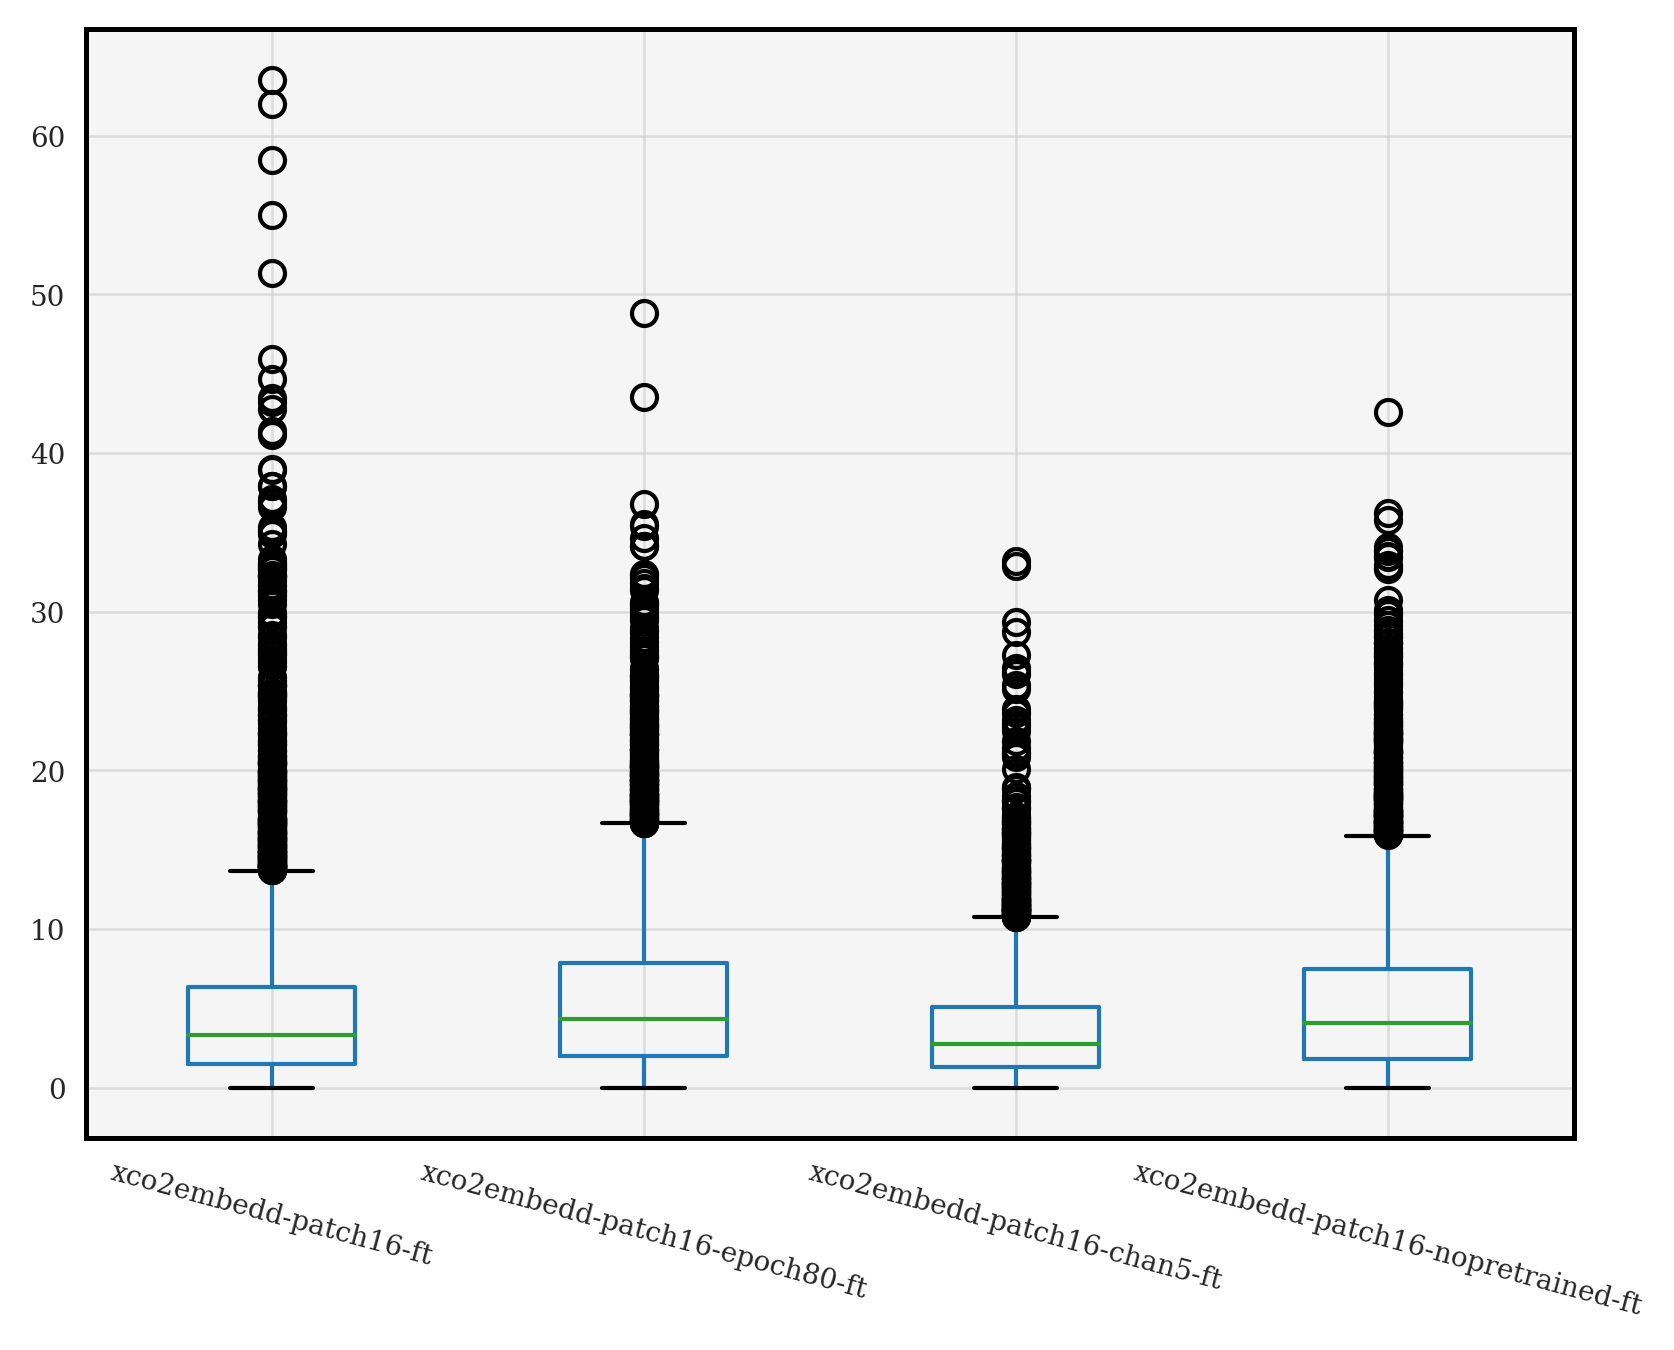

In [24]:
# non-finetuning
runs=["xiaoxubeii-ai/co2-emission-estimation/fyjc6upm", "xiaoxubeii-ai/co2-emission-estimation/0pih6gjx", "xiaoxubeii-ai/co2-emission-estimation/j0ew5kpm"]
alias=["xco2embedd-patch16", "xco2embedd-patch16-epoch80", "xco2embedd-patch16-chan5"]

# finetuning 
runs.extend(["xiaoxubeii-ai/co2-emission-estimation/457pk6dg", "xiaoxubeii-ai/co2-emission-estimation/izbit9gw", "xiaoxubeii-ai/co2-emission-estimation/5wqygzrd"])
alias.extend(["xco2embedd-patch16-ft", "xco2embedd-patch16-epoch80-ft", "xco2embedd-patch16-chan5-ft"])

# no pretrained
runs.extend(["xiaoxubeii-ai/co2-emission-estimation/ufchvlbp"])
alias.extend(["xco2embedd-patch16-nopretrained-ft"])

# cnn
runs.extend(["xiaoxubeii-ai/co2-emission-estimation/9xbr8s7p", "xiaoxubeii-ai/co2-emission-estimation/86s1tltm"])
alias.extend(["squeezenet", "shufflenet"])

test_exps={i:j for i, j in zip(alias, runs)}

r1,r2=get_report(runs, alias)

print(r1)
print(r2)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Already up to date.
HYDRA_FULL_ERROR=1 python /kaggle/working/co2-images-inv-dl/compare_tests.py +test=compare_tests ++tests.test-co2emiss-transformer-win6-patch16-08101948.model_name='transf-win6' ++tests.test-co2emiss-transformer-win6-patch16-08101948.metric_path='/kaggle/working/res/inversion/test-co2emiss-transformer-win6-patch16-08101948/metrics.json' ++tests.test-co2emiss-transformer-win6-patch16-chan5-08111902.model_name='transf-win6-chan5' ++tests.test-co2emiss-transformer-win6-patch16-chan5-08111902.metric_path='/kaggle/working/res/inversion/test-co2emiss-transformer-win6-patch16-chan5-08111902/metrics.json' ++tests.test-co2emiss-cnnlstm-sch2-win6-08101957.model_name='cnnlstm-win6' ++tests.test-co2emiss-cnnlstm-sch2-win6-08101957.metric_path='/kaggle/working/res/inversion/test-co2emiss-cnnlstm-sch2-win6-08101957/metrics.json' ++exp_name='compare-tests-08180139' ++run_tags='[transf-win6, transf-win6-chan5, cnnlstm-win6]' ++git_id='57003d678a2e764507d9ce58c31753ee979dd6f2'


2024-08-18 01:39:10.067887: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-18 01:39:10.093672: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-18 01:39:10.093745: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/kaggle/working/co2-images-inv-dl/Data.py:608: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path="cfg", config_name="config")
/kaggle/working/co2-images-inv-dl/compare_tests.py:35: UserWarning: 
The version_base parameter is not specifie


 
 
 
 
 Run begins 
 
 
 
 

data:
  init:
    _target_: Data.Data_train
    path_train_ds:
    - name: all_hotspots_but_box
      nc: train_dataset.nc
    - name: all_hotspots_but_box
      nc: test_dataset.nc
    path_valid_ds:
    - name: all_hotspots_but_box
      nc: valid_dataset.nc
    path_test_ds:
    - name: boxberg
      nc: train_dataset.nc
    - name: boxberg
      nc: valid_dataset.nc
    - name: boxberg
      nc: test_dataset.nc
    path_data_dir: /Users/xiaoxubeii/Downloads/data_paper_inv_pp
    window_length: 0
    shift: 0
    cutoff_size: 0
  input:
    dir_seg_models: /cerea_raid/users/dumontj/dev/coco2/dl/res/models
    chan_0: xco2
    chan_1: u_wind
    chan_2: v_wind
    chan_3: None
    chan_4: None
  output:
    N_emissions: 1
  path:
    train:
    - name: all_hotspots_but_box
      nc: train_dataset.nc
    - name: all_hotspots_but_box
      nc: test_dataset.nc
    valid:
    - name: all_hotspots_but_box
      nc: valid_dataset.nc
    test:
    - name: boxb

,min,mean,max,std,min,mean,max,std
co2emiss-transf-win6,0.002972,7.446303,37.455254,5.307008,0.019542,74.561113,431.327911,65.466208
co2emiss-transf-win6-chan5,0.001019,7.964801,33.080780,5.510817,0.005202,71.265217,456.646149,74.557851
co2emiss-cnnlstm-win6,0.448360,7.046074,40.858170,6.124799,3.705761,58.854805,331.859161,44.833222


,25%,50%,75%,25%,50%,75%
co2emiss-transf-win6,4.169079,6.933547,9.271105,27.059698,53.932171,105.874941
co2emiss-transf-win6-chan5,3.412795,7.589684,11.529340,17.620893,41.925503,103.590273
co2emiss-cnnlstm-win6,3.493761,5.516138,7.895314,28.915048,47.741028,72.991518


co2emiss-transf-win6&0.0&7.4&37.5&5.3&0.0&74.6&431.3&65.5\\
co2emiss-transf-win6-chan5&0.0&8.0&33.1&5.5&0.0&71.3&456.6&74.6\\
co2emiss-cnnlstm-win6&0.4&7.0&40.9&6.1&3.7&58.9&331.9&44.8\\

co2emiss-transf-win6&4.2&6.9&9.3&27.1&53.9&105.9\\
co2emiss-transf-win6-chan5&3.4&7.6&11.5&17.6&41.9&103.6\\
co2emiss-cnnlstm-win6&3.5&5.5&7.9&28.9&47.7&73.0\\



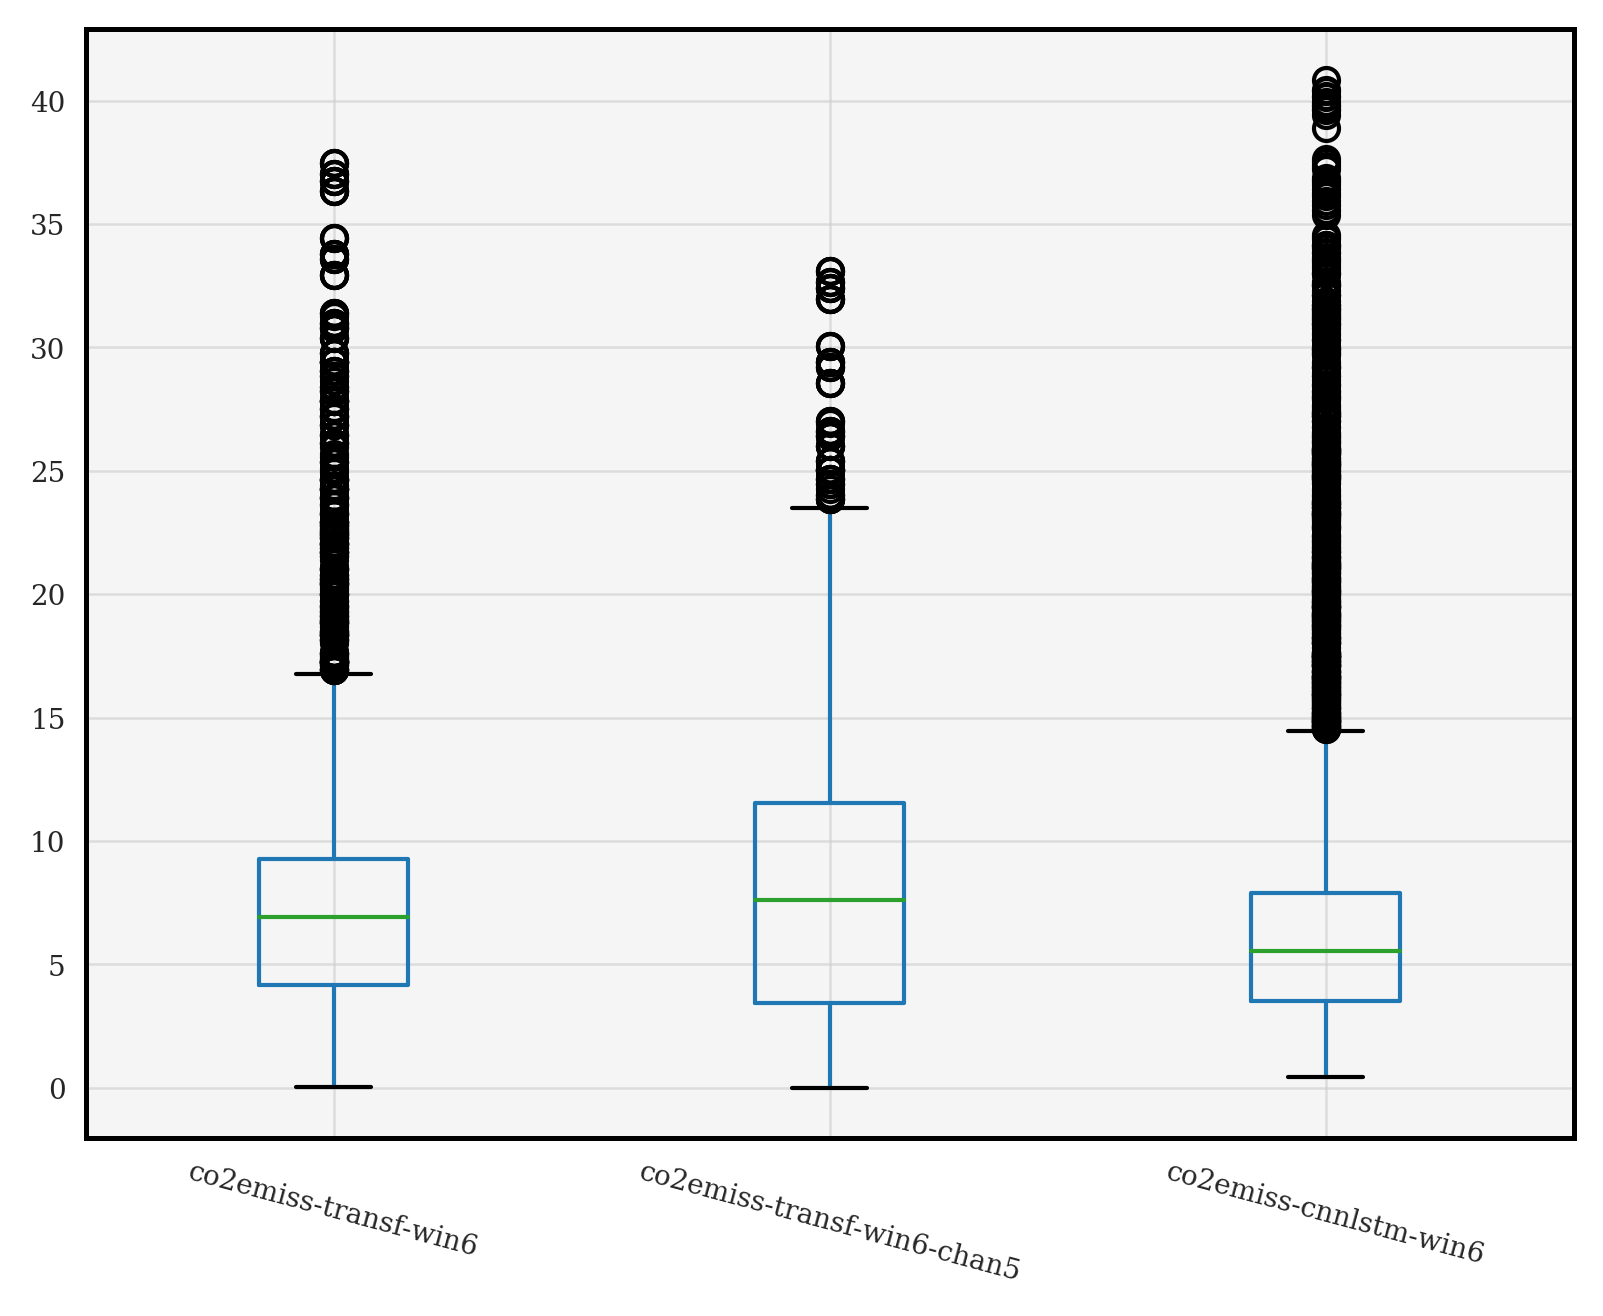

In [17]:
# transformer models
runs=["xiaoxubeii-ai/co2-emission-estimation/27spc9nr", "xiaoxubeii-ai/co2-emission-estimation/4k3g6duj", "xiaoxubeii-ai/co2-emission-estimation/ug5n0mw5",
      "xiaoxubeii-ai/co2-emission-estimation/eapt5v7a","xiaoxubeii-ai/co2-emission-estimation/ygk2grbn","xiaoxubeii-ai/co2-emission-estimation/w93xi2jz", "xiaoxubeii-ai/co2-emission-estimation/clsndtar",
      "xiaoxubeii-ai/co2-emission-estimation/ihci7tbr", "xiaoxubeii-ai/co2-emission-estimation/plhawi8k", 
      "xiaoxubeii-ai/co2-emission-estimation/lqzscxtq", "xiaoxubeii-ai/co2-emission-estimation/to2kzs1g", "xiaoxubeii-ai/co2-emission-estimation/ro3ga9y1",
      "xiaoxubeii-ai/co2-emission-estimation/ahhbqj4c", "xiaoxubeii-ai/co2-emission-estimation/0iozsrc1", "xiaoxubeii-ai/co2-emission-estimation/psmdw0kv", "xiaoxubeii-ai/co2-emission-estimation/d1xzv7nm"
      "xiaoxubeii-ai/co2-emission-estimation/4khwhnmt"]

alias=["transf-sch1-win6","transf-sch2-win6", "transf-sch1-win12",
       "transf-boxberg-win6","transf-boxberg-win12","transf-boxberg-win24", "transf-boxberg-win72",
       "transf-sch2small-win6", "transf-sch2small-win12",
       "transf-sch1-win6-chan5", "transf-sch2-win6-chan5", "transf-sch2small-win6-chan5",
       "cnnlstm-sch1-win12", "cnnlstm-sch2-win6", "cnnlstm-sch1-win6", "cnnlstm-boxberg-win12"
       "cnnlstm-sch2-win6-new"]

exps={i:j for i, j in zip(alias, runs)}

# transformer tests
prefix="co2emiss-%s"
runs=["xiaoxubeii-ai/co2-emission-estimation/4aeyc4ze","xiaoxubeii-ai/co2-emission-estimation/a55b0rt5","xiaoxubeii-ai/co2-emission-estimation/5vr4fqds","xiaoxubeii-ai/co2-emission-estimation/ctxp1o6j",
      "xiaoxubeii-ai/co2-emission-estimation/bia2thfg", "xiaoxubeii-ai/co2-emission-estimation/c9tgayl0",
      "xiaoxubeii-ai/co2-emission-estimation/placqpnx", "xiaoxubeii-ai/co2-emission-estimation/jk3f4291",
      "xiaoxubeii-ai/co2-emission-estimation/6p7ts0ko", "xiaoxubeii-ai/co2-emission-estimation/e44jzt7o"
      "xiaoxubeii-ai/co2-emission-estimation/5k8842vq"]
alias=["transf-sch1-win6","transf-sch2-win6","transf-sch2small-win6","transf-sch2small-win12",
       "transf-boxberg-win24", "transf-boxberg-win72",
       "transf-sch1-win6-chan5", "transf-sch2-win6-chan5",
       "cnnlstm-sch1-win6", "cnnlstm-sch2-win6", "cnnlstm-win6"]
test_exps={i:j for i, j in zip(alias, runs)}

# analyse tests and generate reports
r1,r2=get_report(runs, alias, prefix)

print(r1)
print(r2)